# Sobre o Dataset

O dataset **Chest X-Ray Images (Pneumonia)** contém imagens de radiografias torácicas de pacientes, sendo amplamente utilizado para tarefas de classificação de pneumonia com aprendizado de máquina.

- 📊 **Total de imagens:** 5.863
- 📁 **Divisão em conjuntos:** treino (`train`), validação (`val`) e teste (`test`)
- 🩻 **Classes:**
  - `NORMAL` – pulmões saudáveis
  - `PNEUMONIA` – pulmões com infecção (bacteriana ou viral)
- 🧠 **Objetivo:** treinar modelos de IA para detectar pneumonia com base em exames de raio-X.
- 🔗 **Fonte:** https://www.cell.com/cell/fulltext/S0092-8674(18)30154-5


## 1. Importação das Bibliotecas

In [51]:
import kagglehub
from tensorflow.keras.utils import img_to_array
import shutil
import hashlib
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.utils import class_weight
from sklearn.metrics import classification_report, confusion_matrix
import pandas as pd
import random
import itertools
from tensorflow.keras.optimizers import Adam, RMSprop
from sklearn.model_selection import train_test_split
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import os
from tensorflow.keras.layers import GlobalAveragePooling2D

sns.set(style='whitegrid') # Define o estilo visual dos gráficos do Seaborn com grade branca de fundo

### Caso esteja rodando pela 2ª vez - limpa a pasta, caso seja a 1ª - Não rodar

In [18]:
# Caminho da pasta de destino
dst_dir = './chest_xray'

# 🔁 Apaga a pasta se ela já existir (limpeza total antes de copiar)
if os.path.exists(dst_dir):
    shutil.rmtree(dst_dir)
    print("🧹 Pasta antiga removida.")

# Agora copia novamente os dados do Kaggle
src_dir = os.path.join(path, 'chest_xray')  # ou só `path` se não houver subpasta

if not os.path.exists(src_dir):
    print(f"⚠️ Subpasta 'chest_xray' não encontrada dentro de {path}.")
    print("Conteúdo encontrado:", os.listdir(path))
    src_dir = path

shutil.copytree(src_dir, dst_dir)
print("✅ Dados copiados novamente do zero.")


🧹 Pasta antiga removida.
✅ Dados copiados novamente do zero.


## 🔍 1.1 Carregamento dos Dados

In [19]:
# Download do conjunto de dados do kaggle

path = kagglehub.dataset_download("paultimothymooney/chest-xray-pneumonia")  # Baixa o dataset de raio-X de pneumonia do Kaggle
print("Path to dataset files:", path)  # Exibe o caminho onde os arquivos foram salvos localmente


Path to dataset files: C:\Users\Bruna\.cache\kagglehub\datasets\paultimothymooney\chest-xray-pneumonia\versions\2


In [20]:
## Copia dos Dados para o Diretório de Trabalho

# Define os caminhos
src_dir = os.path.join(path, 'chest_xray')  # pasta principal dentro do dataset
dst_dir = './chest_xray'  # destino no diretório de trabalho atual

# Verifica se a subpasta "chest_xray" realmente existe dentro de `path`
if not os.path.exists(src_dir):
    print(f"⚠️ Subpasta 'chest_xray' não encontrada dentro de {path}. Listando conteúdo:")
    print(os.listdir(path))
    # Se a pasta 'chest_xray' não existir, use `path` diretamente
    src_dir = path

# Copia a pasta completa para o diretório atual
shutil.copytree(src_dir, dst_dir, dirs_exist_ok=True)
print(f"✅ Dados copiados para o diretório de trabalho: {dst_dir}")


✅ Dados copiados para o diretório de trabalho: ./chest_xray


In [21]:
# Definição do diretório base

base_dir = dst_dir

## 🧹 2. Limpeza e Padronização das Imagens

In [22]:
# 📊 CONTAGEM DE IMAGENS POR CONJUNTO E CLASSE

def contar_imagens(diretorio):
    dados = []
    for subset in ['train', 'val', 'test']:  # Percorre os subconjuntos: treino, validação e teste
        for classe in ['NORMAL', 'PNEUMONIA']:  # Percorre as classes: NORMAL e PNEUMONIA
            caminho = os.path.join(diretorio, subset, classe)  # Monta o caminho completo da pasta da classe
            # Conta apenas os arquivos com extensão de imagem
            total = len([f for f in os.listdir(caminho) if f.endswith(('jpg', 'jpeg', 'png'))])
            # Armazena os dados em formato de dicionário
            dados.append({'Conjunto': subset, 'Classe': classe, 'Total': total})
    return pd.DataFrame(dados)  # Retorna um DataFrame com as informações

df_contagem = contar_imagens(base_dir)  # Aplica a função ao diretório base
display(df_contagem)  # Exibe a tabela resultante com a contagem de imagens por conjunto e classe


,Conjunto,Classe,Total
0,train,NORMAL,1341
1,train,PNEUMONIA,3875
2,val,NORMAL,8
3,val,PNEUMONIA,8
4,test,NORMAL,234
5,test,PNEUMONIA,390


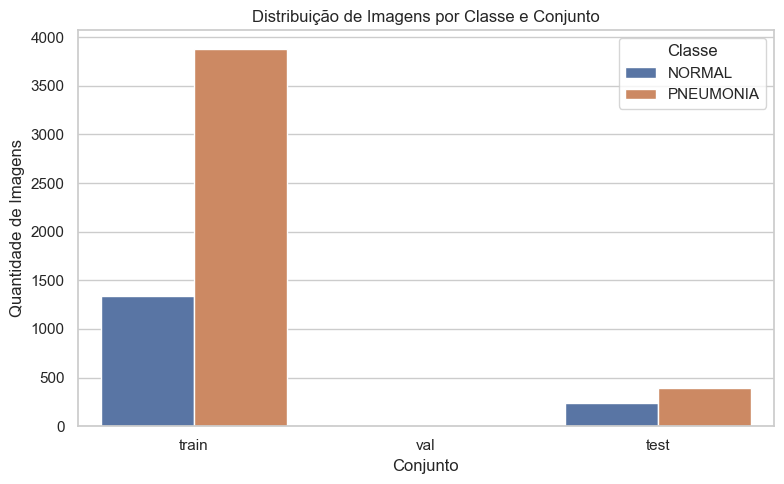

In [23]:
# 📈 VISUALIZAÇÃO DA DISTRIBUIÇÃO DAS IMAGENS

plt.figure(figsize=(8, 5))  # Define o tamanho da figura (largura=8, altura=5)
sns.barplot(data=df_contagem, x='Conjunto', y='Total', hue='Classe')  # Cria um gráfico de barras agrupadas por classe e conjunto
plt.title('Distribuição de Imagens por Classe e Conjunto')  # Título do gráfico
plt.ylabel('Quantidade de Imagens')  # Rótulo do eixo Y
plt.xlabel('Conjunto')  # Rótulo do eixo X
plt.legend(title='Classe')  # Adiciona legenda com título 'Classe'
plt.tight_layout()  # Ajusta o layout para evitar sobreposição
plt.show()  # Exibe o gráfico


### 2.1 Verificação de formatos e canais

In [24]:
# 🔎 VERIFICAÇÃO DOS FORMATOS DAS IMAGENS

def checar_formatos(diretorio):
    formatos = set()  # Conjunto para armazenar combinações únicas de tamanho e modo de cor das imagens
    for subset in ['train', 'val', 'test']:  # Percorre os subconjuntos do dataset
        for classe in ['NORMAL', 'PNEUMONIA']:  # Percorre as duas classes
            pasta = os.path.join(diretorio, subset, classe)  # Caminho da pasta da classe
            for arquivo in os.listdir(pasta):  # Itera sobre os arquivos na pasta
                caminho = os.path.join(pasta, arquivo)  # Caminho completo da imagem
                try:
                    img = Image.open(caminho)  # Abre a imagem com PIL
                    formatos.add((img.size, img.mode))  # Adiciona o tamanho e o modo de cor (RGB, L, etc.) ao conjunto
                except:
                    continue  # Ignora arquivos corrompidos ou inválidos
    return formatos  # Retorna o conjunto de formatos únicos encontrados

formatos = checar_formatos(base_dir)  # Aplica a função ao diretório base
print("Formatos únicos encontrados:", formatos)  # Exibe os tamanhos e modos únicos das imagens


Formatos únicos encontrados: {((1300, 617), 'L'), ((1232, 832), 'L'), ((1589, 1044), 'L'), ((1472, 1360), 'L'), ((1152, 632), 'L'), ((1762, 1715), 'L'), ((1302, 927), 'L'), ((1384, 1080), 'L'), ((1064, 624), 'L'), ((1330, 1133), 'L'), ((1104, 792), 'L'), ((1724, 1476), 'L'), ((864, 640), 'L'), ((1086, 739), 'L'), ((928, 576), 'L'), ((1562, 1348), 'L'), ((1360, 1048), 'L'), ((1664, 1000), 'L'), ((1280, 848), 'L'), ((2172, 1963), 'L'), ((1024, 656), 'L'), ((1568, 1192), 'L'), ((1824, 1384), 'L'), ((550, 279), 'RGB'), ((1184, 1024), 'L'), ((1068, 763), 'L'), ((944, 496), 'L'), ((1348, 812), 'L'), ((1438, 1260), 'L'), ((1350, 1152), 'L'), ((716, 444), 'RGB'), ((490, 189), 'RGB'), ((1592, 1152), 'L'), ((1256, 816), 'L'), ((1088, 648), 'L'), ((968, 832), 'L'), ((1008, 800), 'L'), ((1704, 1544), 'L'), ((1072, 712), 'L'), ((832, 416), 'L'), ((500, 244), 'RGB'), ((1638, 1323), 'L'), ((1294, 1138), 'L'), ((1568, 1120), 'L'), ((659, 363), 'RGB'), ((1088, 672), 'L'), ((1810, 1545), 'L'), ((1152, 5

### 2.2 Função de limpeza (conversão, remoção, hashing)

In [25]:
def imagem_pequena(img, min_size=(100, 100)):
    return img.size[0] < min_size[0] or img.size[1] < min_size[1]

In [26]:
def imagem_duplicada(img, hash_set):
    hash_val = hashlib.md5(img.tobytes()).hexdigest()
    if hash_val in hash_set:
        return True
    hash_set.add(hash_val)
    return False

In [27]:
USE_GRAYSCALE = True

def converter_para_cinza(img):
    if USE_GRAYSCALE:
        return img.convert('L')
    else:
        return img.convert('RGB')

In [28]:
def limpar_e_padronizar_imagens(base_dir):
    hash_set = set()
    total_removidas = 0
    total_convertidas = 0

    print("🧼 Iniciando limpeza e conversão das imagens...")

    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base_dir, subset, classe)
            if not os.path.exists(path):
                print(f"⚠️ Pasta não encontrada: {path}")
                continue

            files = os.listdir(path)
            print(f"\n📂 Processando {subset}/{classe} – {len(files)} arquivos")

            for file in files:
                file_path = os.path.join(path, file)

                try:
                    img = Image.open(file_path)

                    if imagem_pequena(img):
                        os.remove(file_path)
                        total_removidas += 1
                        print(f"🗑️ Removida (pequena): {file}")
                        continue

                    img = converter_para_cinza(img)

                    if imagem_duplicada(img, hash_set):
                        os.remove(file_path)
                        total_removidas += 1
                        print(f"🗑️ Removida (duplicada): {file}")
                        continue

                    img.save(file_path)
                    total_convertidas += 1
                    print(f"✅ Convertida para escala de cinza: {file}")

                except Exception as e:
                    os.remove(file_path)
                    total_removidas += 1
                    print(f"❌ Erro ao processar {file}: {e}")

    print("\n📊 Etapa de limpeza finalizada!")
    print(f"🗑️ Total de imagens removidas: {total_removidas}")
    print(f"✅ Total convertidas e salvas: {total_convertidas}")

    # 🔧 Aplica o redimensionamento final após limpeza
    print("\n📐 Iniciando redimensionamento para tamanho padrão...")


In [29]:
def redimensionar_imagens(base_dir, target_size=(128, 128)):
    total_redimensionadas = 0
    erros = 0

    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            path = os.path.join(base_dir, subset, classe)
            if not os.path.exists(path):
                continue

            for file in os.listdir(path):
                file_path = os.path.join(path, file)
                try:
                    img = Image.open(file_path)
                    img = img.resize(target_size)
                    img.save(file_path)
                    total_redimensionadas += 1
                except Exception as e:
                    erros += 1
                    print(f"❌ Erro ao redimensionar {file}: {e}")

    print(f"✅ Total redimensionadas: {total_redimensionadas}")
    print(f"❌ Erros: {erros}")


In [30]:
redimensionar_imagens(base_dir, target_size=(128, 128))

✅ Total redimensionadas: 5856
❌ Erros: 0


## 📊 2.1 Duplicando os dados

In [31]:
def triplicar_744_validas_com_3_copias(base_dir):
    normal_dir = os.path.join(base_dir, 'train', 'NORMAL')

    # Remove duplicatas anteriores
    for arquivo in os.listdir(normal_dir):
        if arquivo.startswith("dup_"):
            os.remove(os.path.join(normal_dir, arquivo))
    print("🧹 Duplicatas antigas removidas.")

    # Filtra as 744 imagens válidas (com "normal" no nome)
    imagens_validas = [
        f for f in os.listdir(normal_dir)
        if not f.startswith('dup_') and 'normal' in f.lower() and f.lower().endswith(('jpg', 'jpeg', 'png'))
    ]

    print(f"🔍 Encontradas {len(imagens_validas)} imagens 'NORMAL' válidas para triplicar (3 cópias cada).")

    # Cria 3 duplicações por imagem válida
    for i, img in enumerate(imagens_validas):
        origem = os.path.join(normal_dir, img)
        for j in range(3):  # 3 cópias
            destino = os.path.join(normal_dir, f"dup{j}_{i}_{img}")
            shutil.copy(origem, destino)

    total = len(os.listdir(normal_dir))
    print(f"✅ Triplicação finalizada! Total de imagens agora: {total}")
triplicar_744_validas_com_3_copias(base_dir)

🧹 Duplicatas antigas removidas.
🔍 Encontradas 744 imagens 'NORMAL' válidas para triplicar (3 cópias cada).
✅ Triplicação finalizada! Total de imagens agora: 3573


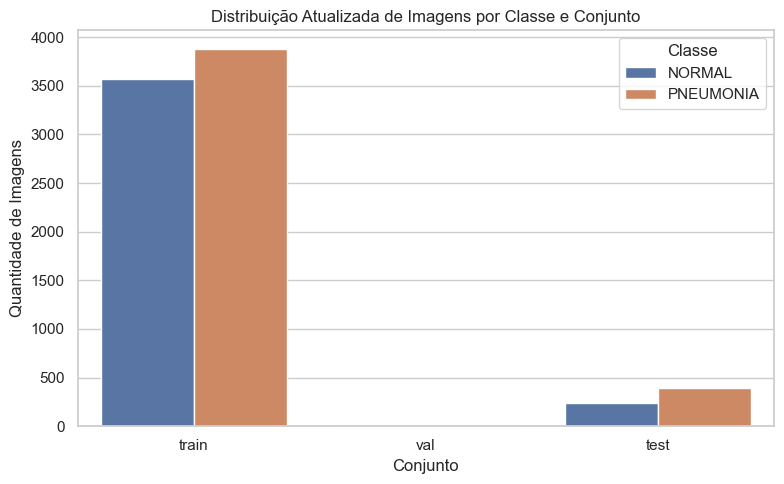

In [32]:
# 🔄 Atualiza a contagem de imagens após a duplicação
df_contagem_atualizada = contar_imagens(base_dir)

# 📈 Visualização da nova distribuição
plt.figure(figsize=(8, 5))
sns.barplot(data=df_contagem_atualizada, x='Conjunto', y='Total', hue='Classe')
plt.title('Distribuição Atualizada de Imagens por Classe e Conjunto')
plt.ylabel('Quantidade de Imagens')
plt.xlabel('Conjunto')
plt.legend(title='Classe')
plt.tight_layout()
plt.show()


## 📊 3. Análise Exploratória dos Dados

In [33]:
# ✅ VERIFICAÇÃO FINAL DO FORMATO DAS IMAGENS PADRONIZADAS

def checar_formato_final(base_dir):
    formatos = set()  # Conjunto para armazenar os formatos únicos encontrados
    for subset in ['train', 'val', 'test']:  # Itera sobre os subconjuntos
        for classe in ['NORMAL', 'PNEUMONIA']:  # Itera sobre as classes
            path = os.path.join(base_dir, subset, classe)  # Caminho da pasta da classe
            for file in os.listdir(path):  # Itera sobre os arquivos da pasta
                img = Image.open(os.path.join(path, file))  # Abre a imagem
                formatos.add((img.size, img.mode))  # Adiciona o tamanho e modo (ex: (128, 128), 'L') ao conjunto
    return formatos  # Retorna os formatos únicos encontrados

print(checar_formato_final(dst_dir))  # Exibe os formatos finais encontrados após a limpeza


{((128, 128), 'L'), ((128, 128), 'RGB')}


In [34]:
def listar_amostras(diretorio):
    for subset in ['train', 'val', 'test']:
        for classe in ['NORMAL', 'PNEUMONIA']:
            pasta = os.path.join(diretorio, subset, classe)
            if os.path.exists(pasta):
                arquivos = os.listdir(pasta)
                print(f"📂 {subset}/{classe} → {len(arquivos)} arquivos")
                print("Exemplos:", arquivos[:3])
            else:
                print(f"❌ Pasta não encontrada: {pasta}")

listar_amostras(dst_dir)


📂 train/NORMAL → 3573 arquivos
Exemplos: ['dup0_0_NORMAL2-IM-0383-0001.jpeg', 'dup0_100_NORMAL2-IM-0513-0001.jpeg', 'dup0_101_NORMAL2-IM-0515-0001.jpeg']
📂 train/PNEUMONIA → 3875 arquivos
Exemplos: ['person1000_bacteria_2931.jpeg', 'person1000_virus_1681.jpeg', 'person1001_bacteria_2932.jpeg']
📂 val/NORMAL → 8 arquivos
Exemplos: ['NORMAL2-IM-1427-0001.jpeg', 'NORMAL2-IM-1430-0001.jpeg', 'NORMAL2-IM-1431-0001.jpeg']
📂 val/PNEUMONIA → 8 arquivos
Exemplos: ['person1946_bacteria_4874.jpeg', 'person1946_bacteria_4875.jpeg', 'person1947_bacteria_4876.jpeg']
📂 test/NORMAL → 234 arquivos
Exemplos: ['IM-0001-0001.jpeg', 'IM-0003-0001.jpeg', 'IM-0005-0001.jpeg']
📂 test/PNEUMONIA → 390 arquivos
Exemplos: ['person100_bacteria_475.jpeg', 'person100_bacteria_477.jpeg', 'person100_bacteria_478.jpeg']


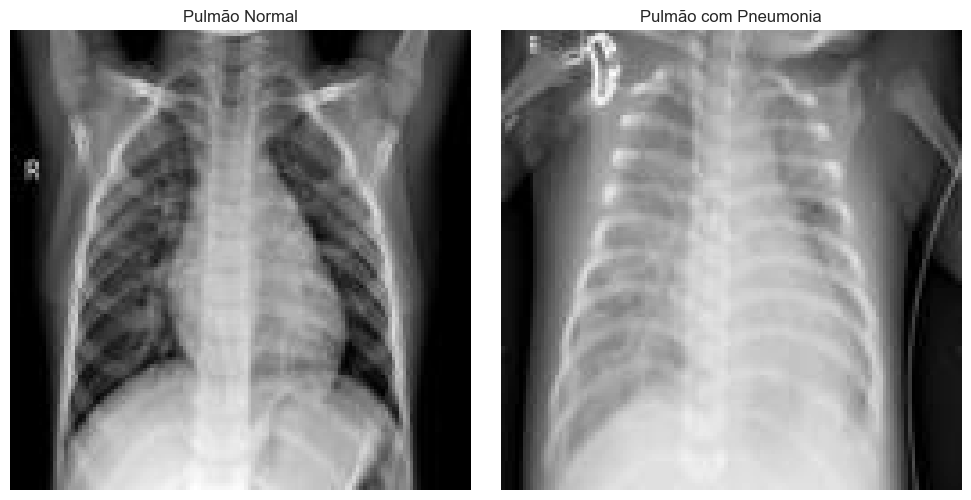

In [35]:
# Caminhos das amostras
caminho_normal = os.path.join(dst_dir, 'train', 'NORMAL')
caminho_pneumonia = os.path.join(dst_dir, 'train', 'PNEUMONIA')

# Pega o primeiro arquivo de cada classe
arquivo_normal = os.listdir(caminho_normal)[0]
arquivo_pneumonia = os.listdir(caminho_pneumonia)[0]

# Abre as imagens
img_normal = Image.open(os.path.join(caminho_normal, arquivo_normal))
img_pneumonia = Image.open(os.path.join(caminho_pneumonia, arquivo_pneumonia))

# Plota lado a lado
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

axes[0].imshow(img_normal, cmap='gray')
axes[0].set_title("Pulmão Normal")
axes[0].axis('off')

axes[1].imshow(img_pneumonia, cmap='gray')
axes[1].set_title("Pulmão com Pneumonia")
axes[1].axis('off')

plt.tight_layout()
plt.show()


In [36]:
for subset in ['train']:
    for classe in ['NORMAL', 'PNEUMONIA']:
        pasta = os.path.join(dst_dir, subset, classe)
        print(f"📂 Classe {classe} – Total de arquivos:", len(os.listdir(pasta)))

📂 Classe NORMAL – Total de arquivos: 3573
📂 Classe PNEUMONIA – Total de arquivos: 3875


## 🧪 4. Pré-processamento para CNN

In [37]:
def carregar_imagens_e_rotulos(diretorio_base, subset):
    imagens = []
    rotulos = []
    classes = ['NORMAL', 'PNEUMONIA']

    for classe_idx, classe_nome in enumerate(classes):
        pasta = os.path.join(diretorio_base, subset, classe_nome)
        for nome_arquivo in os.listdir(pasta):
            caminho = os.path.join(pasta, nome_arquivo)
            try:
                img = Image.open(caminho).convert('L')  # grayscale
                img = img.resize((128, 128))
                img_array = img_to_array(img)
                img_array = np.expand_dims(img_array, axis=-1)

                # 👇 Aqui está o print para debug
                print(f"{nome_arquivo} → {img_array.shape}")

                imagens.append(img_array)
                rotulos.append(classe_idx)
            except Exception as e:
                print(f"⚠️ Erro em {nome_arquivo}: {e}")
                continue
    return np.array(imagens), np.array(rotulos)


In [39]:
#
def carregar_imagens_e_rotulos(diretorio_base, subset):
    imagens = []
    rotulos = []
    classes = ['NORMAL', 'PNEUMONIA']

    for classe_idx, classe_nome in enumerate(classes):
        pasta = os.path.join(diretorio_base, subset, classe_nome)
        for nome_arquivo in os.listdir(pasta):
            caminho = os.path.join(pasta, nome_arquivo)
            try:
                img = Image.open(caminho).convert('L')
                img = img.resize((128, 128))
                img_array = img_to_array(img)  # já resulta em (128, 128, 1)
                imagens.append(img_array)
                rotulos.append(classe_idx)
            except Exception as e:
                print(f"⚠️ Erro ao processar {nome_arquivo}: {e}")
                continue

    return np.array(imagens), np.array(rotulos)

X_treinamento, y_treinamento = carregar_imagens_e_rotulos(dst_dir, 'train')
X_teste, y_teste = carregar_imagens_e_rotulos(dst_dir, 'test')

print("✅ Dados carregados:")
print("X_treinamento:", X_treinamento.shape)
print("X_teste:", X_teste.shape)

X_teste_bin = X_teste
y_teste_bin = y_teste



✅ Dados carregados:
X_treinamento: (7448, 128, 128, 1)
X_teste: (624, 128, 128, 1)


In [40]:
# 🧪 PRÉ-PROCESSAMENTO DOS DADOS DE ENTRADA

# Mostra as dimensões dos conjuntos de treino e teste antes da transformação
print(f"🔍 Antes da normalização – treino: {X_treinamento.shape}, teste: {X_teste.shape}")

# 🔄 Converte os valores dos pixels para float e normaliza para o intervalo [0, 1]
X_treinamento = X_treinamento.astype('float32') / 255
X_teste = X_teste.astype('float32') / 255

# Mostra as novas dimensões dos dados após a normalização
print(f"✅ Depois da normalização – treino: {X_treinamento.shape}, teste: {X_teste.shape}\n")

🔍 Antes da normalização – treino: (7448, 128, 128, 1), teste: (624, 128, 128, 1)
✅ Depois da normalização – treino: (7448, 128, 128, 1), teste: (624, 128, 128, 1)



## 🧠 5. Construção da CNN Customizada

In [52]:
# 🧠 CONFIGURAÇÃO E DEFINIÇÃO DA ARQUITETURA DA CNN

# --- Configuração de Hiperparâmetros da Arquitetura ---
NUM_FILTERS  = 32          # Quantidade de filtros na camada convolucional
KERNEL_SIZE  = (3, 3)      # Tamanho do kernel (janela) da convolução
POOL_SIZE    = (2, 2)      # Tamanho do kernel de pooling (redução espacial)
DENSE_UNITS  = 128         # Número de neurônios na camada densa intermediária
DROPOUT_RATE = 0.2         # Taxa de dropout (20%) para evitar overfitting

# --- Importação dos componentes da rede ---
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Conv2D, BatchNormalization, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping

# Lista de classes
nomes_classes = ['NORMAL', 'PNEUMONIA']

# --- Definição da Arquitetura da CNN ---
rede = Sequential([  # Rede sequencial (feedforward)
    InputLayer(shape=(128, 128, 1)),                 # Camada de entrada para imagens 28x28 com 1 canal
    Conv2D(NUM_FILTERS, KERNEL_SIZE, activation='relu'), # Camada convolucional com ReLU
    BatchNormalization(),                                # Normalização dos dados para melhorar estabilidade
    MaxPooling2D(pool_size=POOL_SIZE),                   # Pooling para redução de dimensionalidade
    #Flatten(),                                           # Achata o mapa de ativação em um vetor 1D
    #Dense(DENSE_UNITS, activation='relu'),               # Camada totalmente conectada com ReLU
    GlobalAveragePooling2D(),
    Dropout(DROPOUT_RATE),                               # Dropout para prevenir overfitting
    Dense(len(nomes_classes), activation='softmax')      # Camada de saída com softmax para classificação multiclasse
])

# 📋 Exibe o resumo da arquitetura da rede (camadas, parâmetros, forma dos dados)
rede.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_2 (Conv2D)               │ (None, 126, 126, 32)   │           320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 126, 126, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 63, 63, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling2d        │ (None, 32)             │             0 │
│ (GlobalAveragePooling2D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 2)              │            66 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 514 (2.01 KB)

 Trainable params: 450 (1.76 KB)

 Non-trainable params: 64 (256.00 B)

In [53]:
# 🧾 VERIFICAÇÃO DAS DIMENSÕES DOS DADOS DE TREINAMENTO

print(X_treinamento.shape)  # Exibe a forma do conjunto de imagens de treino (esperado: (n_amostras, 28, 28, 1))
print(y_treinamento.shape)  # Exibe a forma do vetor de rótulos (esperado: (n_amostras,))

(7448, 128, 128, 1)
(7448,)


In [43]:
# ✅ VERIFICAÇÃO DE VALORES NULOS (NaN) NOS DADOS



print(np.isnan(X_treinamento).sum())  # Verifica se há valores NaN nas imagens de treino (deve retornar 0)
print(np.isnan(y_treinamento).sum())  # Verifica se há valores NaN nos rótulos de treino (deve retornar 0)


0
0


In [54]:
# 🔍 VERIFICAÇÃO DOS TIPOS DE DADOS (dtype)

print(X_treinamento.dtype)  # Mostra o tipo de dados das imagens (esperado: float32 após normalização)
print(y_treinamento.dtype)  # Mostra o tipo de dados dos rótulos (esperado: int32 ou int64 para classificação)


float32
int32


In [45]:
# 🧪 CONVERSÃO DOS TIPOS DE DADOS

X_treinamento = X_treinamento.astype('float32')  # Garante que as imagens estejam no formato float32 (necessário para o TensorFlow)
y_treinamento = y_treinamento.astype('int32')    # Garante que os rótulos estejam como inteiros (int32), exigido por algumas funções de perda
# 🔁 VERIFICAÇÃO FINAL DOS TIPOS DE DADOS APÓS CONVERSÃO

print(X_treinamento.dtype)  # Deve exibir: float32
print(y_treinamento.dtype)  # Deve exibir: int32



float32
int32


In [46]:
# 📐 VERIFICAÇÃO DO FORMATO DAS IMAGENS (PARA REDES SEQUENCIAIS OU CONVOLUCIONAIS)

print(X_treinamento.shape)  # Exibe o shape atual — deve ser algo como (N, 28, 28, 1) para CNNs


(7448, 128, 128, 1)


In [47]:
# 🧱 ACHATAMENTO DAS IMAGENS PARA USO EM REDE DENSAMENTE CONECTADA (MLP)

X_treinamento_flat = X_treinamento.reshape((X_treinamento.shape[0], -1))  # Achata cada imagem 28x28 em um vetor de 784 elementos

print(X_treinamento_flat.shape)  # Exibe a nova forma: (n_amostras, 784) — exemplo: (60000, 784)


(7448, 16384)


In [55]:
# 🔎 FILTRAGEM DOS DADOS PARA CLASSIFICAÇÃO BINÁRIA (NORMAL vs PNEUMONIA)

# Apenas para garantir que os rótulos estejam no formato certo
y_treinamento = y_treinamento.astype('int32')

# Cria uma máscara booleana para selecionar apenas as amostras com rótulos 0 ou 1
mascara_binaria = (y_treinamento == 0) | (y_treinamento == 1)

# Aplica a máscara nos dados de treino
X_treinamento_bin = X_treinamento[mascara_binaria]
y_treinamento_bin = y_treinamento[mascara_binaria]

# Verifica se tudo está certo
print("X_treinamento_bin:", X_treinamento_bin.shape)
print("y_treinamento_bin:", y_treinamento_bin.shape)


X_treinamento_bin: (7448, 128, 128, 1)
y_treinamento_bin: (7448,)


## 🚀 6. Treinamento com EarlyStopping

In [61]:
print("Min:", X_treinamento_bin.min(), "Max:", X_treinamento_bin.max())

Min: 0.0 Max: 1.0


In [76]:


# 🔧 Hiperparâmetros
BATCH_SIZE        = 32
EPOCHS            = 20
PATIENCE          = 3
VALIDATION_SPLIT  = 0.2
OPTIMIZER         = 'adam'

# 🧠 Arquitetura da rede (corrigido input_shape → shape)
rede = Sequential([
    InputLayer(shape=(128, 128, 1)),                   # Substituído para evitar o warning
    Conv2D(32, (3, 3), activation='relu'),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    GlobalAveragePooling2D(),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(2, activation='softmax')  # saída para 2 classes
])

# 🛠️ Compilação do modelo
rede.compile(
    loss='sparse_categorical_crossentropy',
    optimizer=OPTIMIZER,
    metrics=['accuracy']
)

# ⚖️ Pesos de classe
pesos = class_weight.compute_class_weight(
    class_weight='balanced',
    classes=np.unique(y_treinamento_bin),
    y=y_treinamento_bin
)
class_weights = dict(enumerate(pesos))

# ⏹️ EarlyStopping
early_stopping = EarlyStopping(
    monitor='val_loss',
    patience=PATIENCE,
    restore_best_weights=True
)

# 🔀 Separar treino e validação
X_train, X_val, y_train, y_val = train_test_split(
    X_treinamento_bin, y_treinamento_bin,
    test_size=VALIDATION_SPLIT,
    stratify=y_treinamento_bin,
    random_state=42
)

# 🔄 Data Augmentation
datagen = ImageDataGenerator(
    rotation_range=10,
    width_shift_range=0.1,
    height_shift_range=0.1,
    zoom_range=0.1
)
datagen.fit(X_train)

# 🚀 Treinamento com dados aumentados
treinamento = rede.fit(
    datagen.flow(X_train, y_train, batch_size=BATCH_SIZE),
    validation_data=(X_val, y_val),
    epochs=EPOCHS,
    class_weight=class_weights,
    callbacks=[early_stopping],
    verbose=1
)


C:\Users\Bruna\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 192ms/step - accuracy: 0.6852 - loss: 0.6143 - val_accuracy: 0.5201 - val_loss: 1.0788
Epoch 2/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 196ms/step - accuracy: 0.8207 - loss: 0.4095 - val_accuracy: 0.5201 - val_loss: 0.9536
Epoch 3/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 40s 211ms/step - accuracy: 0.8513 - loss: 0.3618 - val_accuracy: 0.6141 - val_loss: 0.6653
Epoch 4/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 39s 205ms/step - accuracy: 0.8473 - loss: 0.3609 - val_accuracy: 0.5886 - val_loss: 0.9569
Epoch 5/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 37s 200ms/step - accuracy: 0.8536 - loss: 0.3591 - val_accuracy: 0.5510 - val_loss: 0.9982
Epoch 6/20
187/187 ━━━━━━━━━━━━━━━━━━━━ 38s 202ms/step - accuracy: 0.8730 - loss: 0.3319 - val_accuracy: 0.4805 - val_loss: 2.3805


In [77]:
resultado = rede.evaluate(X_teste, y_teste)
print(f"📈 Acurácia no teste: {resultado[1]:.4f} | Perda: {resultado[0]:.4f}")


20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 29ms/step - accuracy: 0.7721 - loss: 0.4684
📈 Acurácia no teste: 0.5128 | Perda: 0.8126


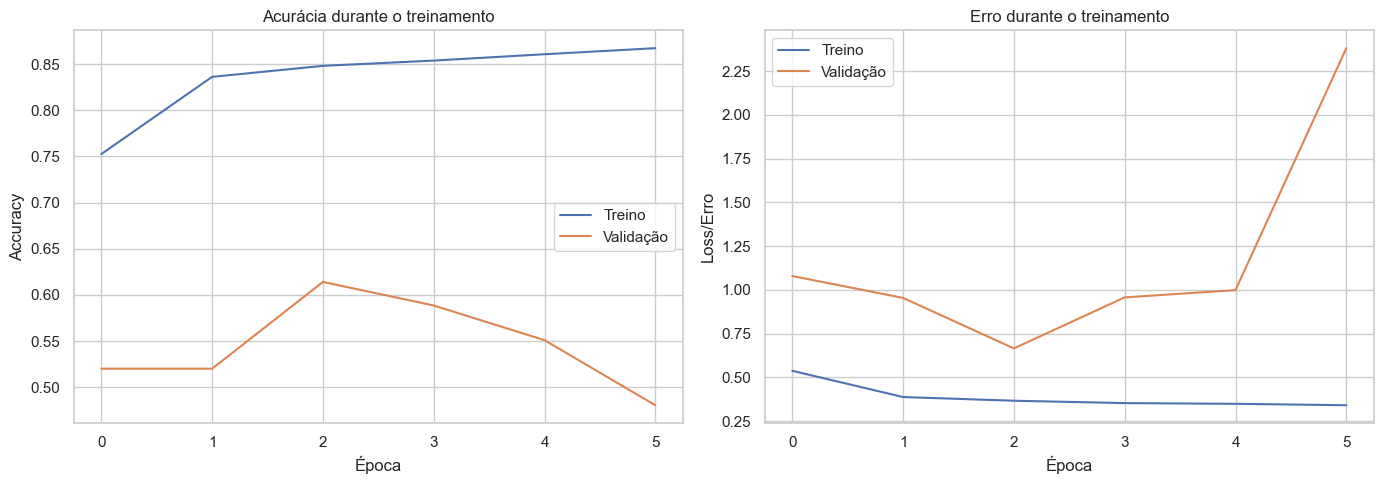

In [78]:
# 📊 PLOTS DAS MÉTRICAS DE TREINAMENTO

fig, axes = plt.subplots(1, 2, figsize=(14, 5))  # Cria dois subgráficos lado a lado em uma figura de tamanho 14x5

# 📈 Gráfico da acurácia por época
axes[0].plot(treinamento.history['accuracy'], label='Treino')           # Linha da acurácia no conjunto de treino
axes[0].plot(treinamento.history['val_accuracy'], label='Validação')    # Linha da acurácia no conjunto de validação
axes[0].set_title('Acurácia durante o treinamento')                     # Título do gráfico
axes[0].set_xlabel('Época')                                             # Rótulo do eixo X
axes[0].set_ylabel('Accuracy')                                          # Rótulo do eixo Y
axes[0].legend()                                                        # Exibe a legenda

# 📉 Gráfico da perda (erro) por época
axes[1].plot(treinamento.history['loss'], label='Treino')               # Linha da perda no conjunto de treino
axes[1].plot(treinamento.history['val_loss'], label='Validação')        # Linha da perda no conjunto de validação
axes[1].set_title('Erro durante o treinamento')                         # Título do gráfico
axes[1].set_xlabel('Época')                                             # Rótulo do eixo X
axes[1].set_ylabel('Loss/Erro')                                         # Rótulo do eixo Y
axes[1].legend()                                                        # Exibe a legenda

plt.tight_layout()  # Ajusta o espaçamento entre os subplots
plt.show()         # Exibe os gráficos

20/20 ━━━━━━━━━━━━━━━━━━━━ 1s 32ms/step
              precision    recall  f1-score   support

      NORMAL       0.43      0.99      0.60       234
   PNEUMONIA       0.98      0.23      0.37       390

    accuracy                           0.51       624
   macro avg       0.71      0.61      0.49       624
weighted avg       0.77      0.51      0.46       624



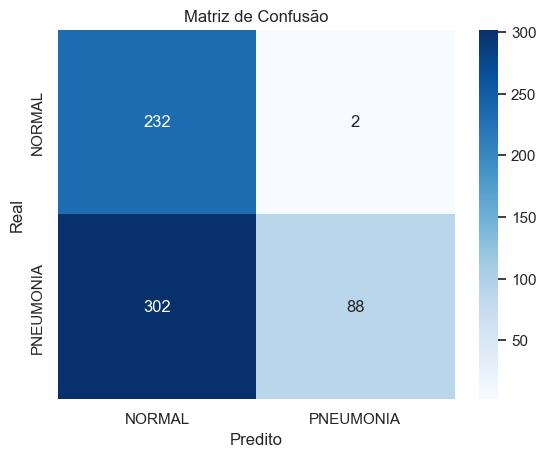

In [79]:

# Previsões
y_pred = np.argmax(rede.predict(X_teste), axis=1)

# Relatório
print(classification_report(y_teste, y_pred, target_names=['NORMAL', 'PNEUMONIA']))

# Matriz de confusão
cm = confusion_matrix(y_teste, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['NORMAL', 'PNEUMONIA'], yticklabels=['NORMAL', 'PNEUMONIA'])
plt.xlabel('Predito')
plt.ylabel('Real')
plt.title('Matriz de Confusão')
plt.show()

In [80]:
# 🧪 FILTRAGEM DO CONJUNTO DE TESTE PARA CLASSIFICAÇÃO BINÁRIA

# Cria uma máscara para manter apenas as amostras com rótulo 0 ou 1
mask_teste_bin = y_teste <= 1

# Aplica a máscara para filtrar o conjunto de teste
X_teste_bin = X_teste[mask_teste_bin]      # Imagens com rótulos 0 ou 1
y_teste_bin = y_teste[mask_teste_bin]      # Rótulos correspondentes (0 = NORMAL, 1 = PNEUMONIA)


In [211]:
# 🧪 FILTRAGEM DO CONJUNTO DE TESTE PARA CLASSIFICAÇÃO BINÁRIA

# Cria uma máscara para manter apenas as amostras com rótulo 0 ou 1
mask_teste_bin = y_teste <= 1

# Aplica a máscara para filtrar o conjunto de teste
X_teste_bin = X_teste[mask_teste_bin]      # Imagens com rótulos 0 ou 1
y_teste_bin = y_teste[mask_teste_bin]      # Rótulos correspondentes (0 = NORMAL, 1 = PNEUMONIA)


## 🧾 7. Avaliação no Conjunto de Teste

## 🔁 8. Validação Cruzada com K-Fold

In [82]:
# 🔁 AVALIAÇÃO COM K-FOLD CROSS-VALIDATION (5 PARTIÇÕES ESTRATIFICADAS)

from sklearn.model_selection import StratifiedKFold  # Importa o validador KFold com estratificação

resultados = []  # Lista para armazenar os resultados de cada iteração

# 🧼 Filtra os dados para conter apenas classes 0 e 1 (NORMAL e PNEUMONIA)
mask_bin = y_treinamento <= 1
X_treinamento = X_treinamento[mask_bin]
y_treinamento = y_treinamento[mask_bin]

# 🔀 Cria um KFold estratificado com 5 divisões, embaralhando os dados
kfold = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# 🔂 Loop pelas divisões do KFold
for i_treino, i_teste in kfold.split(X_treinamento, y_treinamento):

    # 🔧 Cria uma nova instância do modelo para cada fold
    rede_cv = Sequential([
        InputLayer(shape=(128, 128, 1)),                            # Camada de entrada
        Conv2D(NUM_FILTERS, KERNEL_SIZE, activation='relu'),           # Camada convolucional
        BatchNormalization(),                                          # Normalização
        MaxPooling2D(pool_size=POOL_SIZE),                             # Pooling
        Flatten(),                                                     # Achata o mapa de ativação
        Dense(DENSE_UNITS, activation='relu'),                         # Camada densa intermediária
        Dropout(DROPOUT_RATE),                                         # Dropout para evitar overfitting
        Dense(len(nomes_classes), activation='softmax')                # Camada de saída com softmax
    ])

    # ⚠️ Aqui está o problema: você está usando `softmax` com 2 classes → mude para `sigmoid` e `binary_crossentropy`
    # (se nomes_classes = ['NORMAL', 'PNEUMONIA'], len(nomes_classes) = 2, mas o modelo está tratando como multiclasse)

    rede_cv.compile(
        loss='sparse_categorical_crossentropy',  # Usa função de perda para classificação com rótulos inteiros
        optimizer=OPTIMIZER,
        metrics=['accuracy']
    )

    # ▶️ Treina o modelo com os dados do fold atual
    rede_cv.fit(
        X_treinamento[i_treino], y_treinamento[i_treino],         # Dados de treino do fold
        batch_size=BATCH_SIZE,
        epochs=2,
        validation_split=VALIDATION_SPLIT,                         # Divide parte dos dados de treino para validação interna
        callbacks=[early_stopping]
    )

    # 📊 Avalia o modelo com os dados de teste do fold e salva o resultado
    resultados.append(rede_cv.evaluate(X_treinamento[i_teste], y_treinamento[i_teste]))


Epoch 1/2
149/149 ━━━━━━━━━━━━━━━━━━━━ 61s 317ms/step - accuracy: 0.8709 - loss: 2.5102 - val_accuracy: 0.9362 - val_loss: 0.3963
Epoch 2/2
149/149 ━━━━━━━━━━━━━━━━━━━━ 47s 319ms/step - accuracy: 0.9813 - loss: 0.0629 - val_accuracy: 0.9539 - val_loss: 0.2342
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - accuracy: 0.9884 - loss: 0.2110
Epoch 1/2
149/149 ━━━━━━━━━━━━━━━━━━━━ 54s 351ms/step - accuracy: 0.8375 - loss: 2.7486 - val_accuracy: 0.9765 - val_loss: 0.3000
Epoch 2/2
149/149 ━━━━━━━━━━━━━━━━━━━━ 48s 320ms/step - accuracy: 0.9892 - loss: 0.0421 - val_accuracy: 0.9933 - val_loss: 0.1138
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 41ms/step - accuracy: 0.7623 - loss: 0.4487
Epoch 1/2
149/149 ━━━━━━━━━━━━━━━━━━━━ 55s 360ms/step - accuracy: 0.8482 - loss: 4.8134 - val_accuracy: 0.9849 - val_loss: 0.3697
Epoch 2/2
149/149 ━━━━━━━━━━━━━━━━━━━━ 50s 334ms/step - accuracy: 0.9746 - loss: 0.0714 - val_accuracy: 0.9874 - val_loss: 0.2029
47/47 ━━━━━━━━━━━━━━━━━━━━ 2s 38ms/step - accuracy: 0.9540 - loss: 0.367

In [83]:
# 📈 CÁLCULO DAS MÉTRICAS MÉDIAS E DESVIO PADRÃO DO K-FOLD

resultados = np.array(resultados)        # Converte a lista de resultados para um array NumPy (n_folds, 2)
losses = resultados[:, 0]                # Extrai as perdas (loss) de cada fold
accuracies = resultados[:, 1]            # Extrai as acurácias de cada fold

# 📊 Calcula a média e o desvio padrão da perda e da acurácia
media_loss, std_loss = np.mean(losses), np.std(losses)
media_acc, std_acc   = np.mean(accuracies), np.std(accuracies)

# 🖨️ Exibe os resultados finais com 4 casas decimais
print(f'📊 Média dos erros: {media_loss:.4f} ± {std_loss:.4f}')
print(f'📊 Média das acurácias: {media_acc:.4f} ± {std_acc:.4f}')


📊 Média dos erros: 0.2963 ± 0.0411
📊 Média das acurácias: 0.9239 ± 0.0471


# 🔬 9. Tuning de Hiperparâmetros (Grid Search) – A implementar

In [85]:

# --- Parâmetros de busca ---
param_grid = {
    'num_filters': [16, 32],
    'kernel_size': [(3, 3), (5, 5)],
    'dropout_rate': [0.2, 0.5],
    'optimizer': ['adam', 'rmsprop']
}

# Nome das classes (binária)
num_classes = 2

# 🔀 Divisão dos dados
X_train_gs, X_val_gs, y_train_gs, y_val_gs = train_test_split(
    X_treinamento_bin, y_treinamento_bin, test_size=0.2, stratify=y_treinamento_bin, random_state=42
)

# 🔁 Geração aleatória de combinações
todas_combinacoes = list(itertools.product(
    param_grid['num_filters'],
    param_grid['kernel_size'],
    param_grid['dropout_rate'],
    param_grid['optimizer']
))
amostras_escolhidas = random.sample(todas_combinacoes, 5)

# 📊 Resultados
resultados_grid = []

# 🔄 Treinamento para cada combinação escolhida
for nf, ks, dr, opt_name in amostras_escolhidas:
    print(f"🔧 Treinando com filtros={nf}, kernel={ks}, dropout={dr}, optimizer={opt_name}")

    # Escolha do otimizador
    opt = Adam() if opt_name == 'adam' else RMSprop()

    # Modelo leve
    modelo = Sequential([
        InputLayer(shape=(128, 128, 1)),
        Conv2D(nf, ks, activation='relu'),
        BatchNormalization(),
        MaxPooling2D(pool_size=(2, 2)),
        GlobalAveragePooling2D(),
        Dense(64, activation='relu'),
        Dropout(dr),
        Dense(num_classes, activation='softmax')
    ])

    modelo.compile(optimizer=opt,
                   loss='sparse_categorical_crossentropy',
                   metrics=['accuracy'])

    hist = modelo.fit(
        X_train_gs, y_train_gs,
        validation_data=(X_val_gs, y_val_gs),
        batch_size=128,
        epochs=2,
        verbose=1  # mostra progresso
    )

    acc = hist.history['val_accuracy'][-1]
    loss = hist.history['val_loss'][-1]
    resultados_grid.append({
        'filtros': nf,
        'kernel': ks,
        'dropout': dr,
        'optimizer': opt_name,
        'val_accuracy': acc,
        'val_loss': loss
    })

# 📋 Exibe resultados em DataFrame ordenado
df_grid = pd.DataFrame(resultados_grid)
df_grid = df_grid.sort_values(by='val_accuracy', ascending=False)
display(df_grid)


🔧 Treinando com filtros=32, kernel=(5, 5), dropout=0.5, optimizer=rmsprop
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 60s 931ms/step - accuracy: 0.6567 - loss: 0.6410 - val_accuracy: 0.5201 - val_loss: 0.7092
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 37s 774ms/step - accuracy: 0.7612 - loss: 0.5458 - val_accuracy: 0.5201 - val_loss: 0.8485
🔧 Treinando com filtros=16, kernel=(3, 3), dropout=0.2, optimizer=rmsprop
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 22s 412ms/step - accuracy: 0.6302 - loss: 0.6687 - val_accuracy: 0.5201 - val_loss: 0.6961
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 397ms/step - accuracy: 0.7510 - loss: 0.5963 - val_accuracy: 0.5201 - val_loss: 0.7260
🔧 Treinando com filtros=16, kernel=(5, 5), dropout=0.2, optimizer=rmsprop
Epoch 1/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 19s 382ms/step - accuracy: 0.6940 - loss: 0.6487 - val_accuracy: 0.5201 - val_loss: 0.7066
Epoch 2/2
47/47 ━━━━━━━━━━━━━━━━━━━━ 17s 351ms/step - accuracy: 0.7907 - loss: 0.5426 - val_accuracy: 0.5201 - val_loss: 0.8225
🔧 Treinand

,filtros,kernel,dropout,optimizer,val_accuracy,val_loss
0,32,"(5, 5)",0.5,rmsprop,0.520134,0.848486
1,16,"(3, 3)",0.2,rmsprop,0.520134,0.726040
2,16,"(5, 5)",0.2,rmsprop,0.520134,0.822521
3,32,"(3, 3)",0.2,rmsprop,0.520134,0.774308
4,16,"(5, 5)",0.5,adam,0.520134,0.753087


# 🧠 10. Arquitetura Clássica da Literatura – A implementar


# 📊 11. Comparação dos Resultados


# ✅ 12. Conclusão e Aprendizados
